In [45]:
import pandas as pd
import numpy as np
from bff_processor.Systogram import Systogram
from bff_processor.bff_meta import *
from bff_processor.sig_op_func import *
from bff_processor.bff_cuts import bff_1, bff_2, reg_filter
from bff_processor.plotting_utils import unc_plot, boost2unc
from bff_processor.utils import nratio_plot_template, hist2unc, vunc2nom, chiSquared, color_map, quad, linear, constant
import os
import re
from time import perf_counter
import boost_histogram as bh
import pyarrow.feather as feather
import zfit
from zfit import z
from math import pi
import mplhep as hep
hep.style.use(hep.style.CMS)
plt.rcParams.update({
    "text.usetex": True,
})
from zfit.models.physics import DoubleCB
from scipy.optimize import curve_fit
from zfit.models.physics import double_crystalball_func

from bff_plotting_tools.make_hists import make_hist
from bff_plotting_tools.data_getter import get_data
from bff_signal_model.bff_signal_model import bff_signal_model, reset_params, mu

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import pickle

In [48]:
x_range = [110,800]
obs = zfit.Space("x", limits=x_range)

In [49]:
era = '2018'
df, lumi = get_data(era)
compute_hesse=True

In [50]:
from bff_signal_model.utils import get_unique_masses, make_plot_dict, make_stack_plot, compute_bin_centers, sigma_from_mass

In [44]:
masses = get_unique_masses(df)
#masses = np.array([150])
plot_dict,plot_dict_centered, param_list = make_plot_dict(df, obs, masses, compute_hesse=compute_hesse)

125.0
139
150.0
139
175.0
139
200.0
139
250.0
139
300.0
139
350.0
139
400.0
139
450.0
139
500.0
139
125.0
139
150.0
139
175.0
139
200.0
139
250.0
139
300.0
139
350.0
139
400.0
139
450.0
139
500.0
139


In [51]:
pdf = pd.DataFrame(param_list)
pdf['fitted mass'] = pdf.mu/.995 - 0.57839198
pdf

,reg,mass,mu,mu_error,fitted mass
0,SR1,125.0,124.983376,0.000736,125.033041
1,SR1,150.0,149.880159,0.000651,150.054934
2,SR1,175.0,174.797353,0.000680,175.097340
3,SR1,200.0,199.683947,0.000501,200.108991
4,SR1,250.0,249.498067,0.000682,250.173434
5,SR1,300.0,299.326342,0.000927,300.252103
6,SR1,350.0,349.214531,0.001236,350.390986
7,SR1,400.0,398.924700,0.001616,400.350955
8,SR1,450.0,448.579898,0.002016,450.255676
9,SR1,500.0,498.489171,0.002644,500.415749


In [52]:
if compute_hesse: pdf.to_csv('fits/bff/bff_mass_only_model_fit_{}.csv'.format(era))

[]
[]


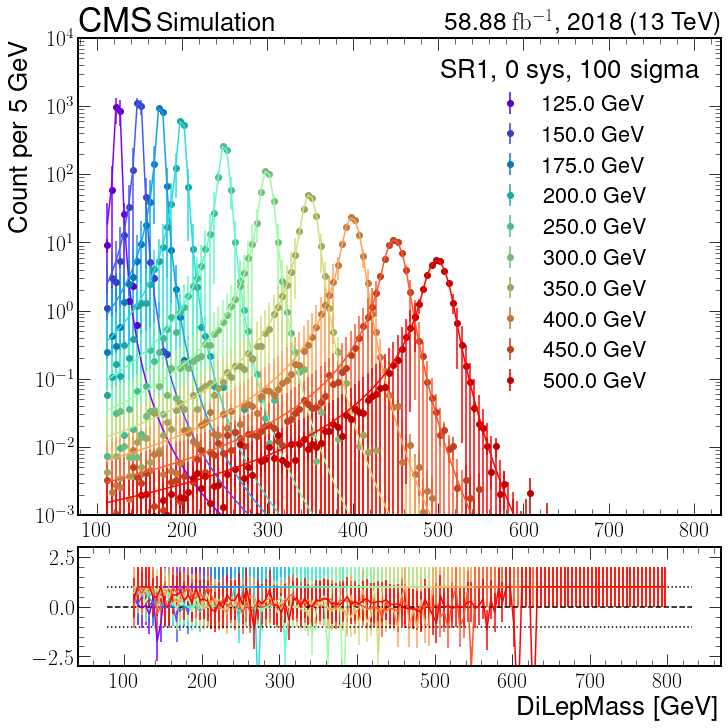

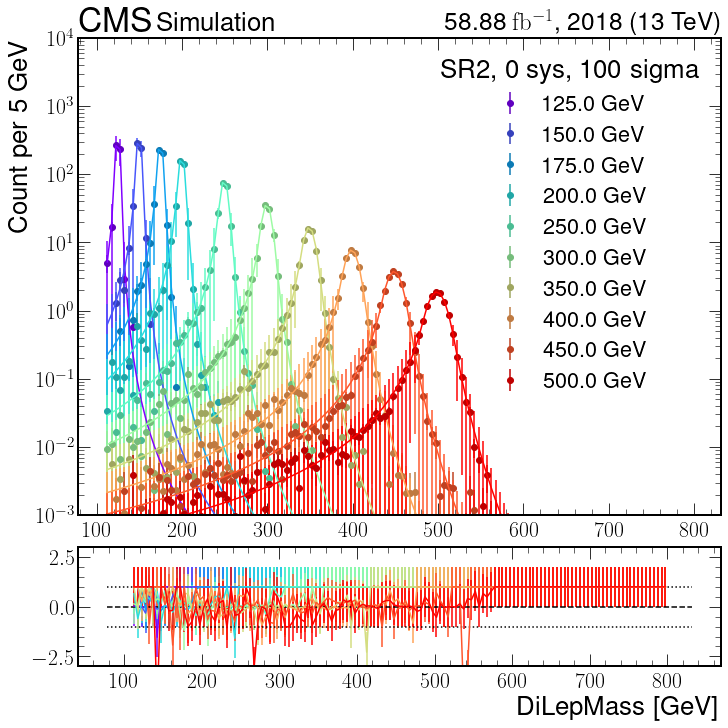

In [53]:
_ = make_stack_plot(plot_dict, masses, pdf, lumi, era, compute_hesse, yscale='log')

In [54]:
pdf

,reg,mass,mu,mu_error,fitted mass,chi2
0,SR1,125.0,124.983376,0.000736,125.033041,0.836437
1,SR1,150.0,149.880159,0.000651,150.054934,0.747659
2,SR1,175.0,174.797353,0.000680,175.097340,0.751542
3,SR1,200.0,199.683947,0.000501,200.108991,0.717889
4,SR1,250.0,249.498067,0.000682,250.173434,0.725368
5,SR1,300.0,299.326342,0.000927,300.252103,0.719530
6,SR1,350.0,349.214531,0.001236,350.390986,0.633474
7,SR1,400.0,398.924700,0.001616,400.350955,0.565540
8,SR1,450.0,448.579898,0.002016,450.255676,0.497485
9,SR1,500.0,498.489171,0.002644,500.415749,0.434973


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


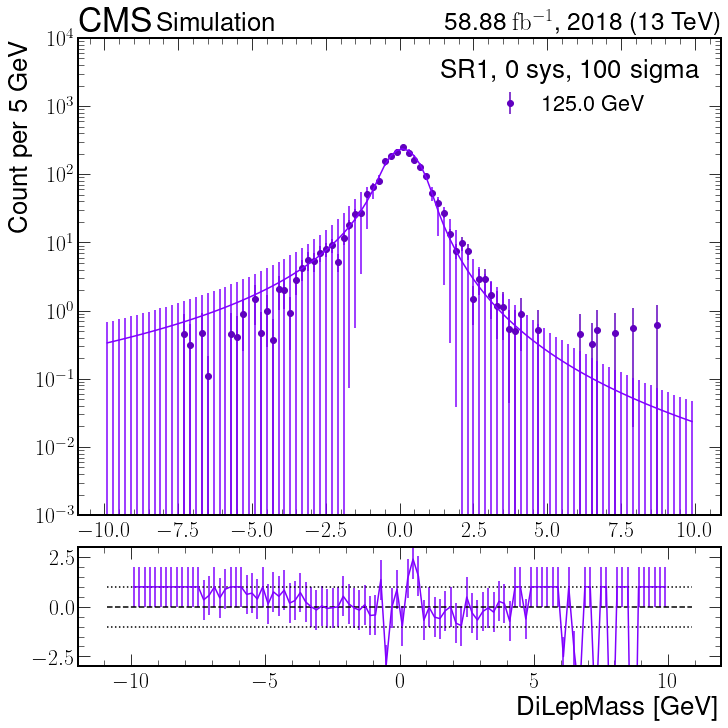

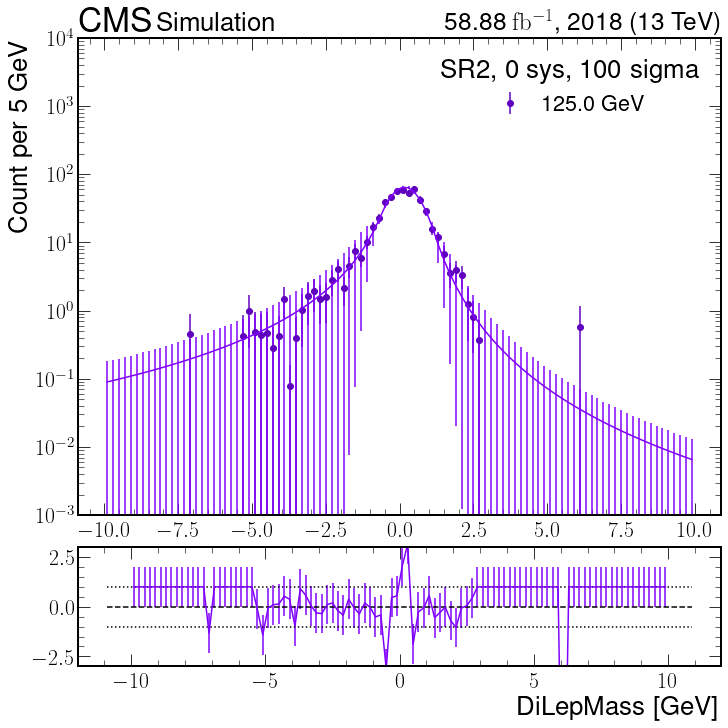

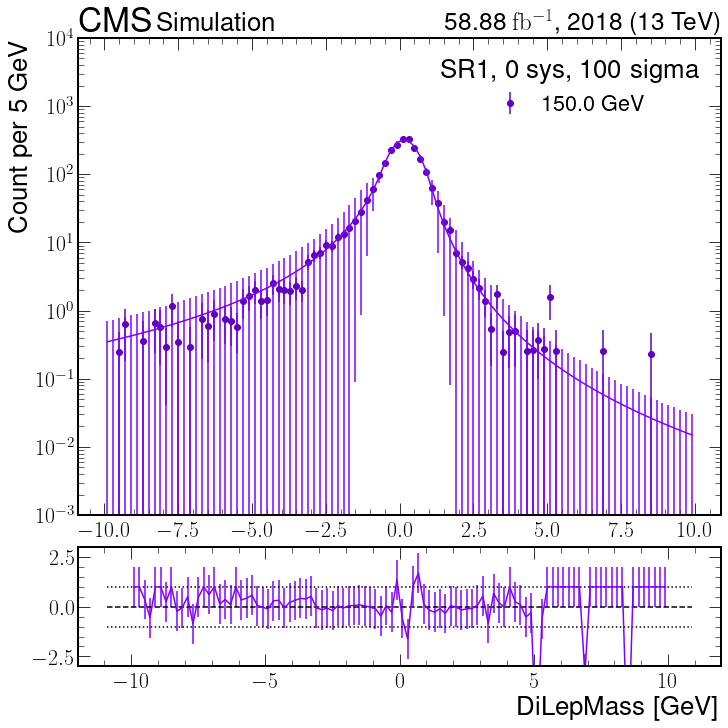

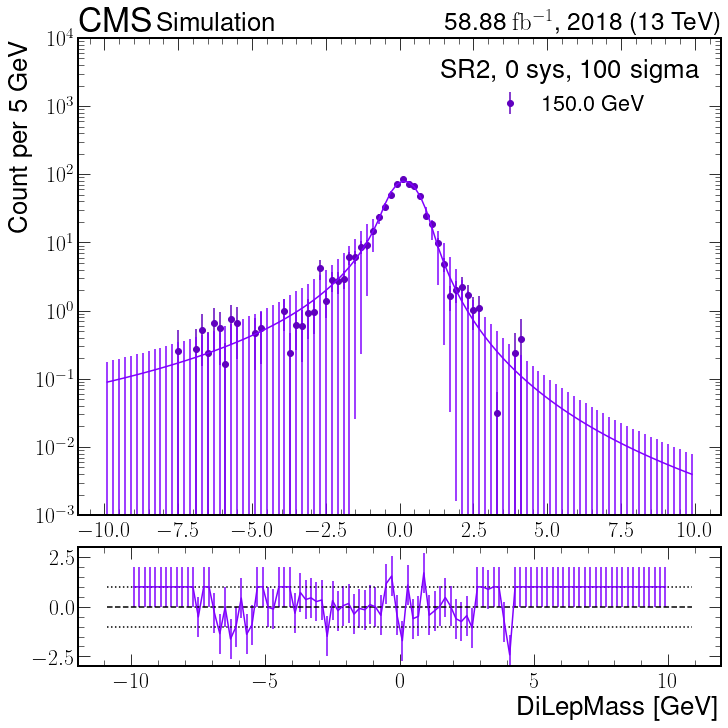

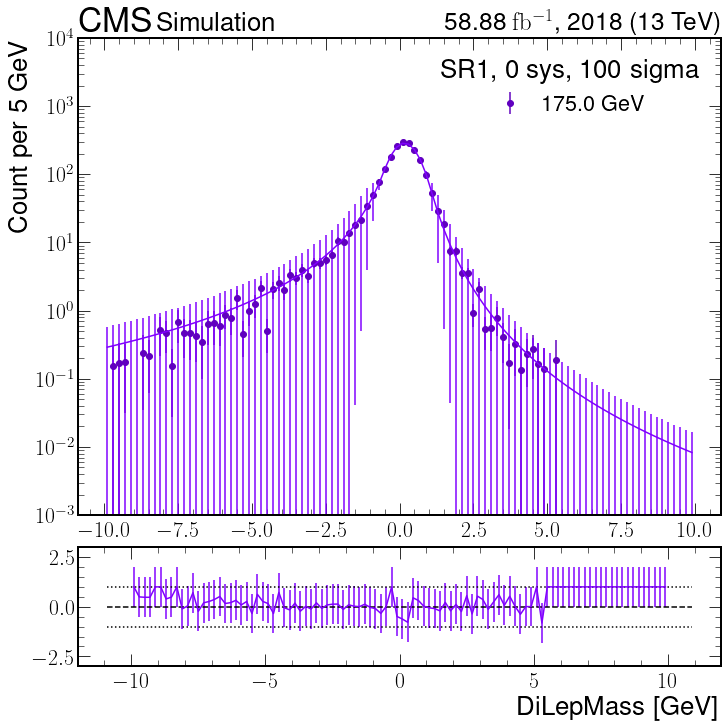

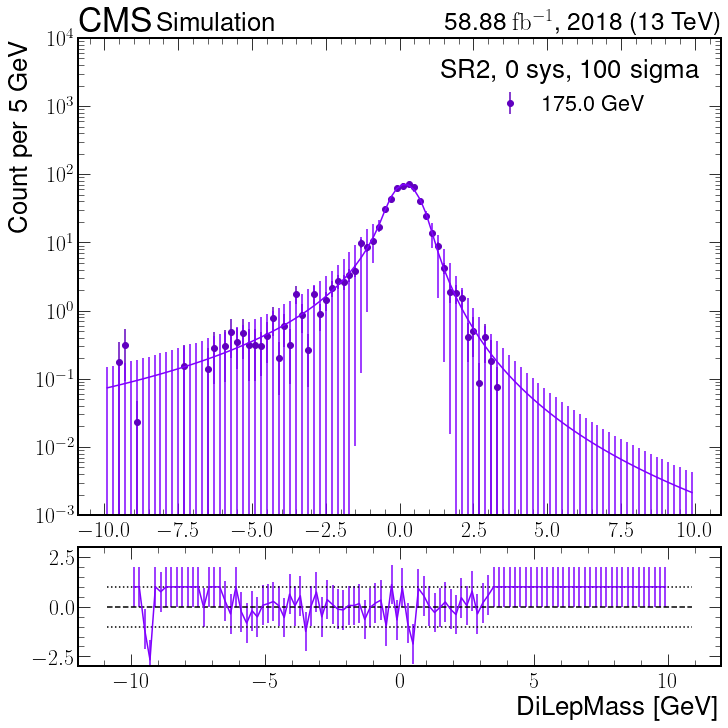

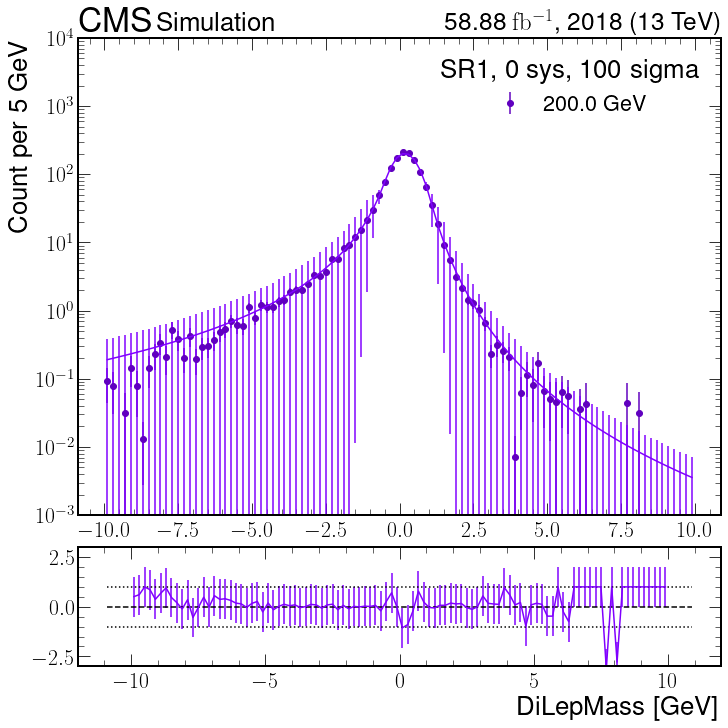

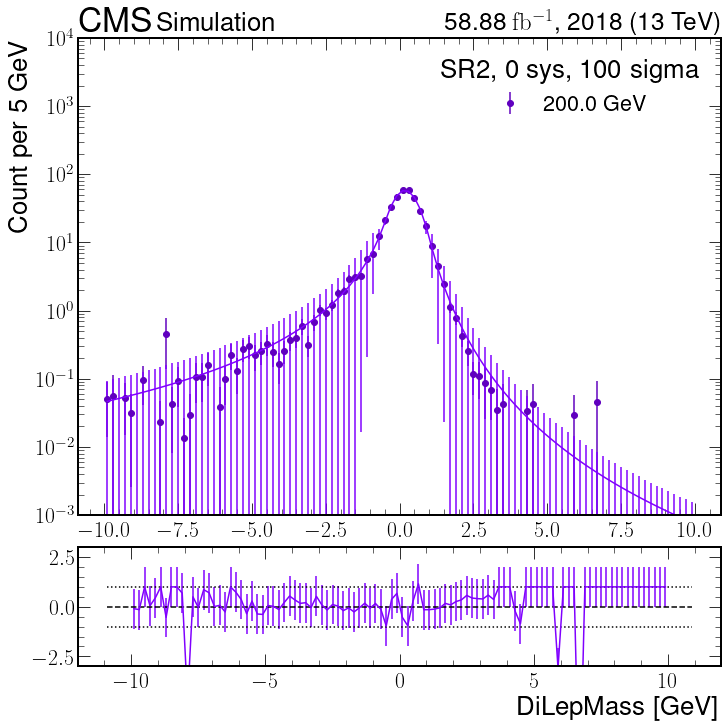

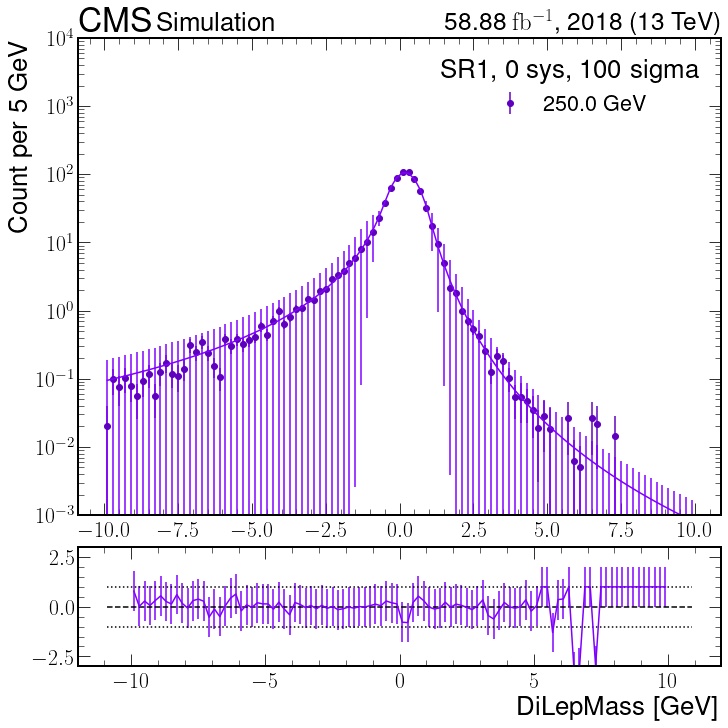

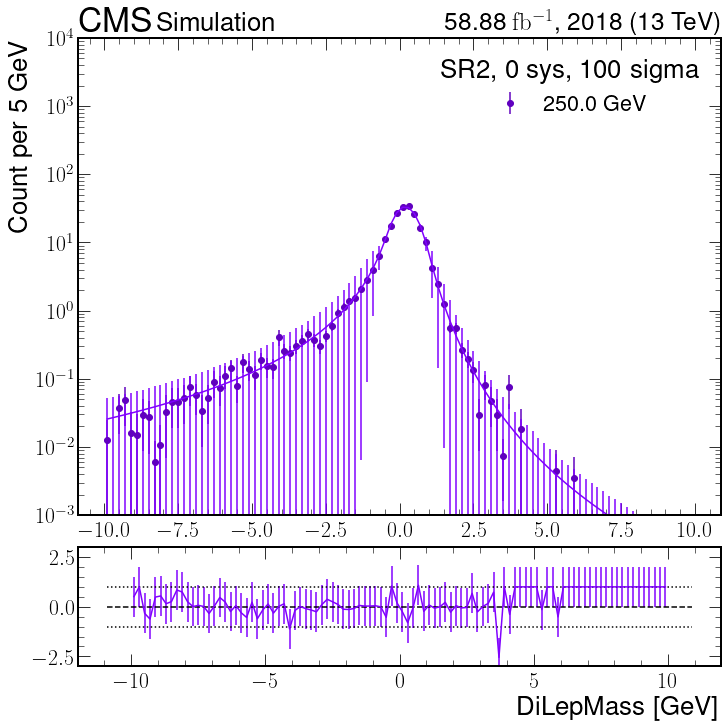

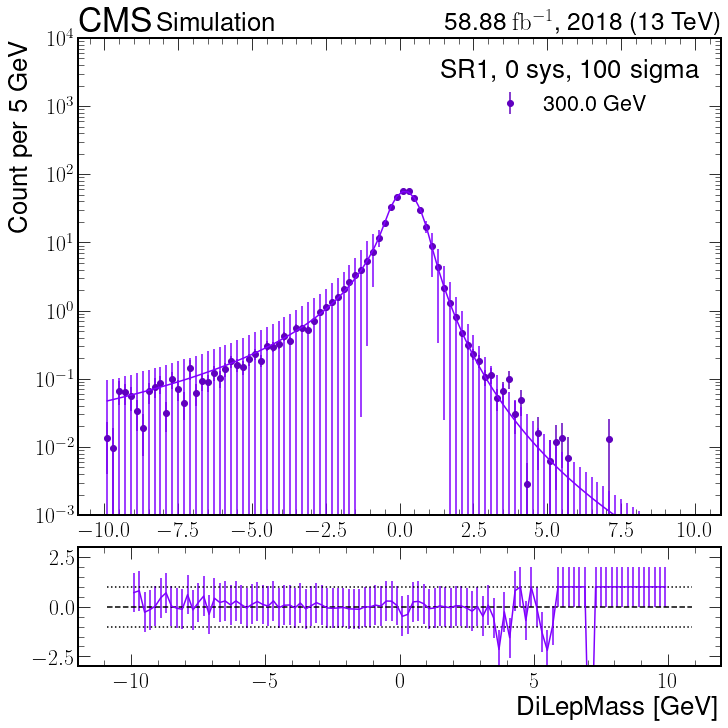

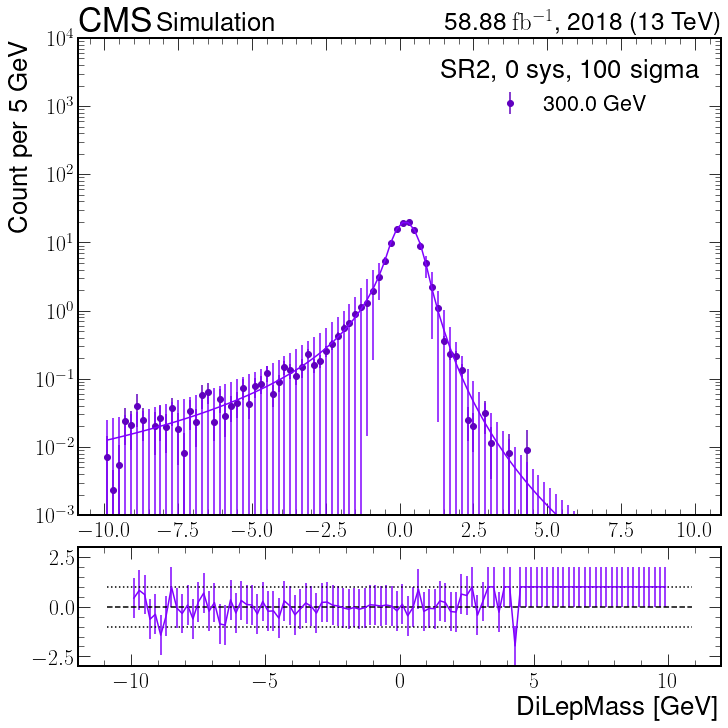

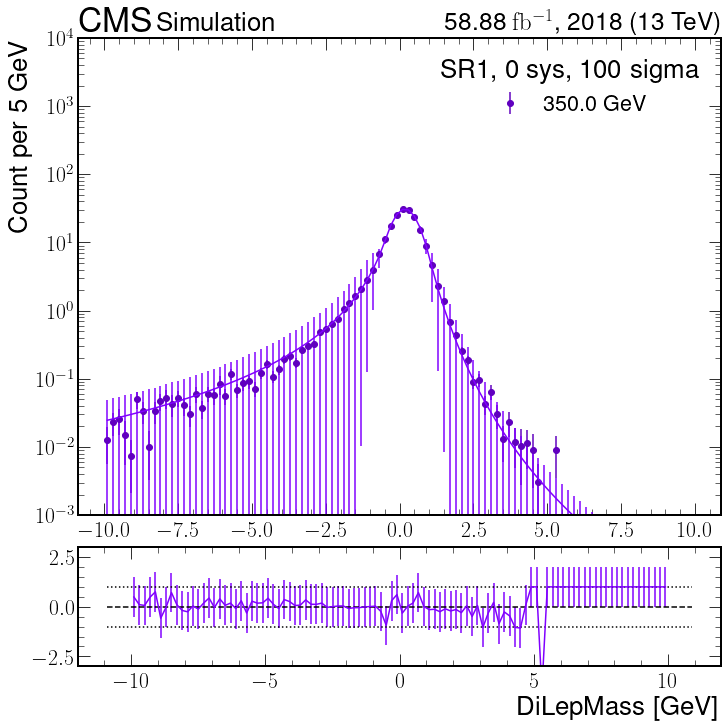

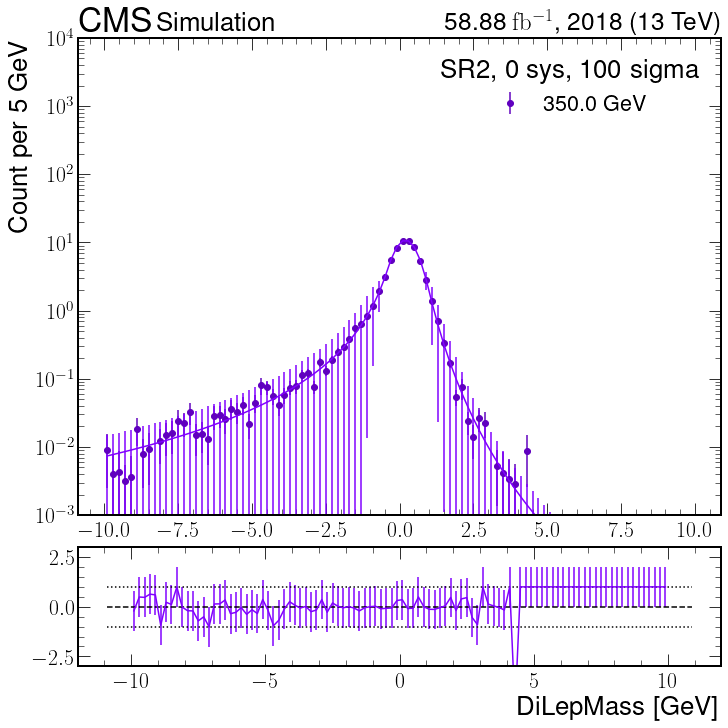

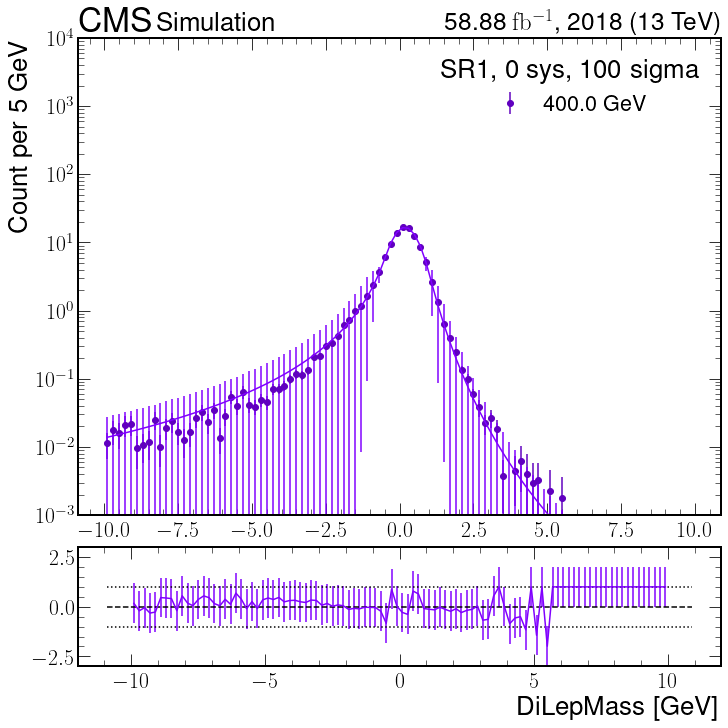

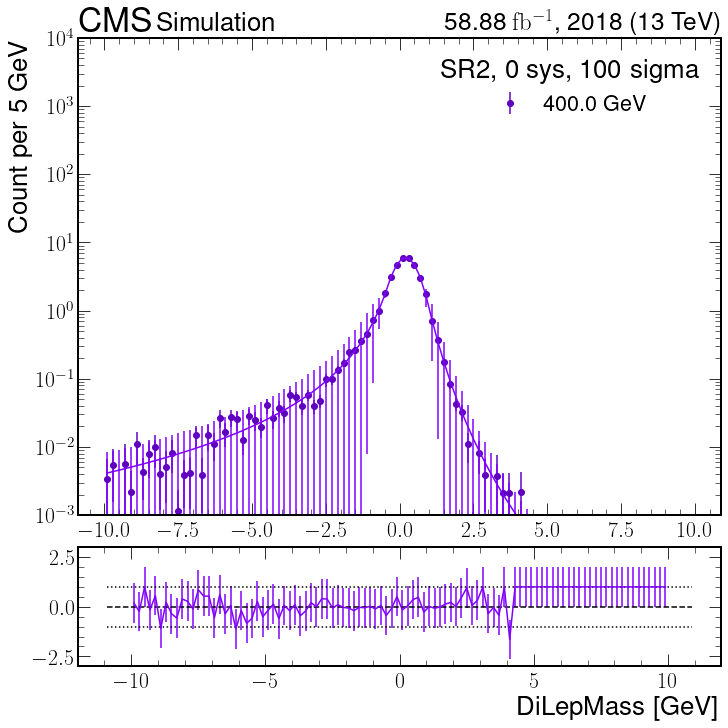

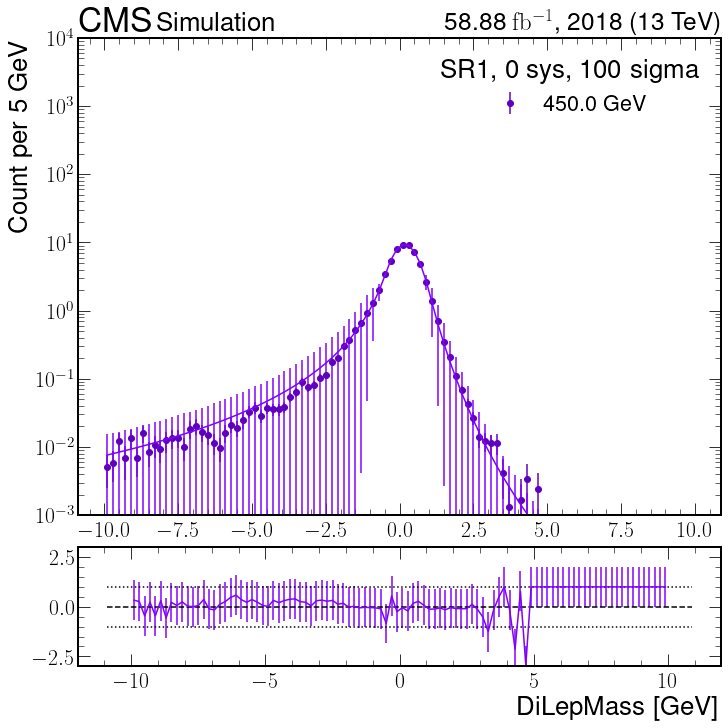

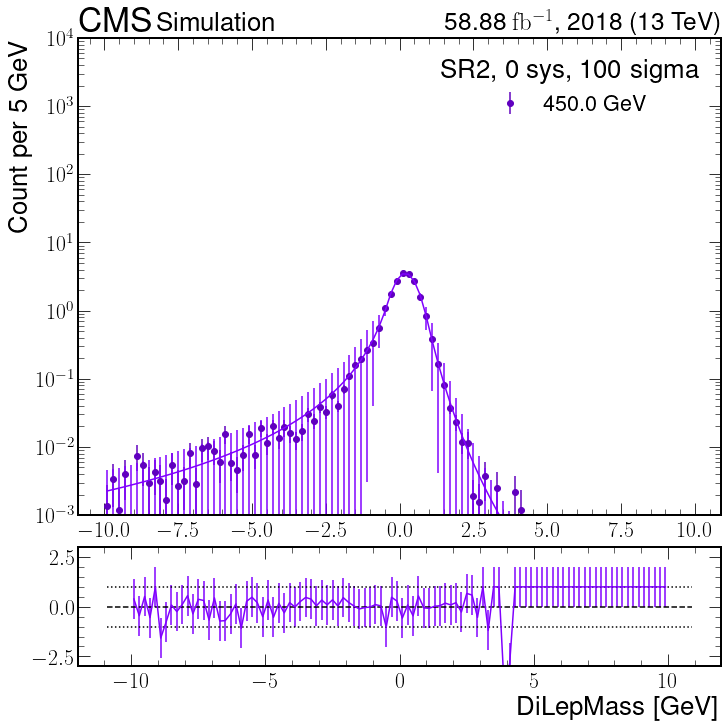

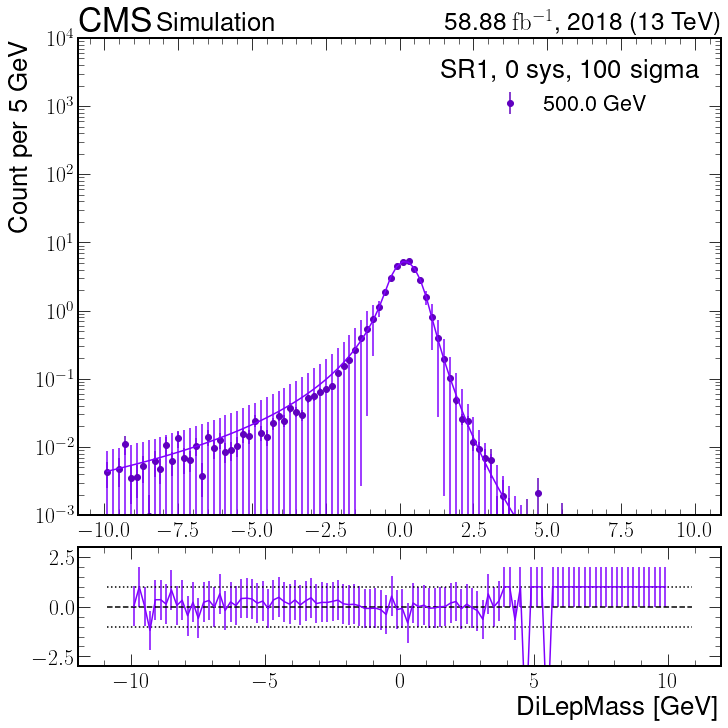

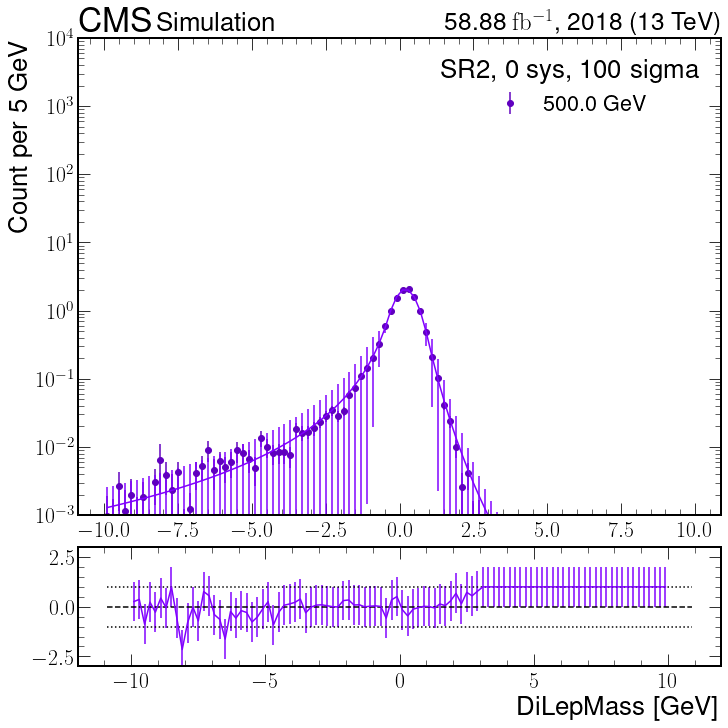

In [55]:
for mass in masses:
    make_stack_plot(plot_dict_centered, [mass], pdf, lumi, era, compute_hesse,postfix="_{}".format(mass))

[]
[]


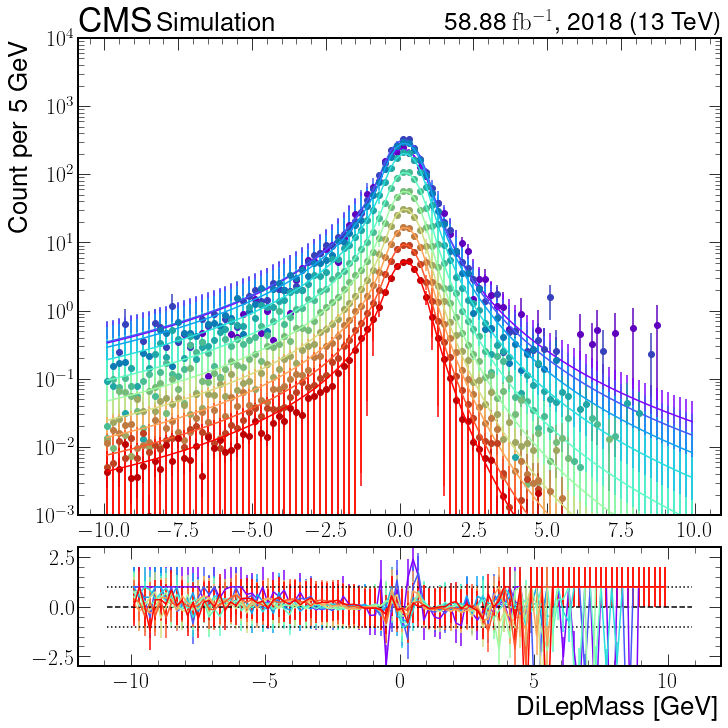

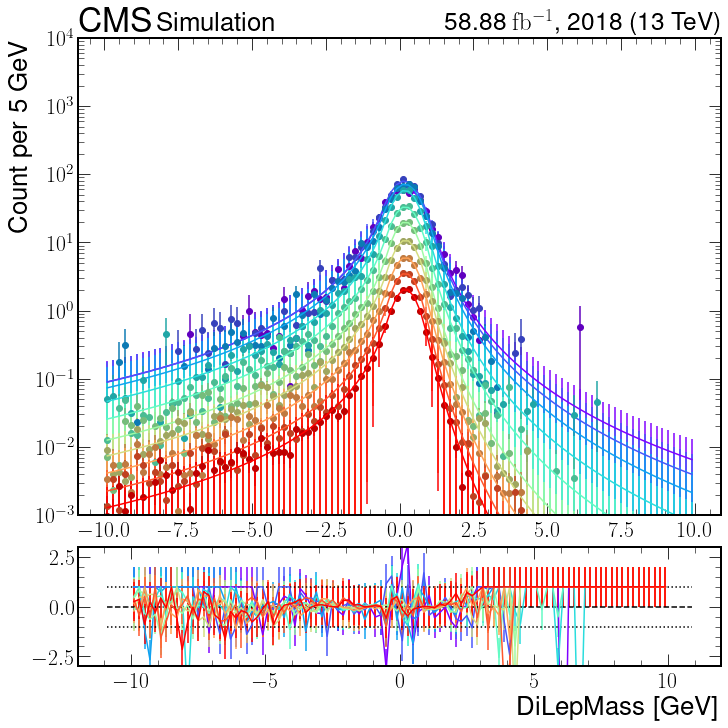

In [56]:
residual_dict = make_stack_plot(plot_dict_centered, masses, pdf, lumi, era, compute_hesse, legend=False,
                              bottom_limit=[-3,3], postfix="_centered")

In [57]:
if compute_hesse: pdf.to_csv('fits/bff/bff_mass_only_model_fit_{}.csv'.format(era))
pdf

,reg,mass,mu,mu_error,fitted mass,chi2
0,SR1,125.0,124.983376,0.000736,125.033041,0.631442
1,SR1,150.0,149.880159,0.000651,150.054934,0.457619
2,SR1,175.0,174.797353,0.000680,175.097340,0.357829
3,SR1,200.0,199.683947,0.000501,200.108991,0.296694
4,SR1,250.0,249.498067,0.000682,250.173434,0.272735
5,SR1,300.0,299.326342,0.000927,300.252103,0.337764
6,SR1,350.0,349.214531,0.001236,350.390986,0.349015
7,SR1,400.0,398.924700,0.001616,400.350955,0.344998
8,SR1,450.0,448.579898,0.002016,450.255676,0.354544
9,SR1,500.0,498.489171,0.002644,500.415749,0.385141


In [58]:
print(pdf.round(3).to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} &  reg &   mass &       mu &  mu\_error &  fitted mass &   chi2 \\
\midrule
0  &  SR1 &  125.0 &  124.983 &     0.001 &      125.033 &  0.631 \\
1  &  SR1 &  150.0 &  149.880 &     0.001 &      150.055 &  0.458 \\
2  &  SR1 &  175.0 &  174.797 &     0.001 &      175.097 &  0.358 \\
3  &  SR1 &  200.0 &  199.684 &     0.001 &      200.109 &  0.297 \\
4  &  SR1 &  250.0 &  249.498 &     0.001 &      250.173 &  0.273 \\
5  &  SR1 &  300.0 &  299.326 &     0.001 &      300.252 &  0.338 \\
6  &  SR1 &  350.0 &  349.215 &     0.001 &      350.391 &  0.349 \\
7  &  SR1 &  400.0 &  398.925 &     0.002 &      400.351 &  0.345 \\
8  &  SR1 &  450.0 &  448.580 &     0.002 &      450.256 &  0.355 \\
9  &  SR1 &  500.0 &  498.489 &     0.003 &      500.416 &  0.385 \\
10 &  SR2 &  125.0 &  124.928 &     0.001 &      124.977 &  0.699 \\
11 &  SR2 &  150.0 &  149.844 &     0.001 &      150.018 &  0.659 \\
12 &  SR2 &  175.0 &  174.781 &     0.001 &      175.081 & 

In [59]:
def gs_plot(xrange, yrange, **kwargs):
    fig = plt.figure(constrained_layout=True, **kwargs)
    gs = fig.add_gridspec(xrange,yrange)
    for x in range(xrange):
        for y in range(yrange):
            fig.add_subplot(gs[x,y])
    return fig

In [60]:
from scipy.optimize import curve_fit

In [61]:
def constant(x, b):
    return linear(x, b, 0)

def linear(x, b, m):
    return m * x + b

def quad(x, b, m, m2):
    return m2 * x ** 2 + m * x + b

In [62]:
def make_hist(
              df, 
              axismeta, axisname, 
              weightname,
              regionname,
              typename,
              variablename,
              uniquelabels=[]
             ):

    ldf = df[(df[regionname]==1) & (df.type==typename)]
    values = ldf[variablename]
    weights = ldf[weightname]
    labels = ldf['labels']
    if uniquelabels==[]:
        uniquelabels =  np.unique(labels)
    
    dr_hist = (hist.Hist.new
               .StrCat(uniquelabels, name = "labels")
               .Reg(*axismeta, name=axisname)
               .Weight())
    
    dr_hist.fill(labels, values, weight=weights)
    return dr_hist

In [63]:
def make_type_hists(
              df, 
              axismeta, axisname, 
              weightname,
              regionname,
              variablename,
              data = 1
             ):
    uniquelabels = ['DiBoson', 'ST', 'TT', 'DY']
    typename = 'bck'
    bck_hist = make_hist(df, axismeta, axisname, weightname,regionname,typename,
                         variablename,
                         uniquelabels=uniquelabels)
    
    typename = 'sig'
    sig_hist = make_hist(df, axismeta, axisname, weightname,regionname,typename,
                        variablename,)
    
    if data:
        typename = 'data'
        data_hist = make_hist(df, axismeta, axisname, weightname,regionname,typename,
                             variablename,)
        return bck_hist, sig_hist, data_hist
    else:
        return bck_hist, sig_hist

In [64]:
def make_sys(df,  axismeta, axisname, regiontemplate, weightname, bck_hist, sig_hist, variablename,
            regionname):  
    sys_array = []
    sig_sys_array = []
    for jetcorr in ['jer', 'jesTotal']:
        cor = []
        sig_cor = []
        for direction in ['Up','Down']:
            correction = '{}{}'.format(jetcorr, direction)
            regionnamesys = regiontemplate.format(correction)
            bck_hist_corr_temp, sig_hist_corr_tem = make_type_hists( df,  axismeta, axisname,  
                                                                    weightname, regionnamesys, 
                                                                    variablename,
                                                                    data=0)
            cor.append(bck_hist_corr_temp[::sum,:].values()-bck_hist[::sum,:].values())
            sig_cor.append(sig_hist_corr_tem.values()-sig_hist.values())
            
        cor = sorted(cor, key=lambda x: np.sum(x))
        sig_cor = sorted(sig_cor, key=lambda x: np.sum(x))
        sys_array.append(cor)
        sig_sys_array.append(sig_cor)
        
    weightsys = ["Weight_Pu","Weight_BTag","Weight_PUID","Weight_PDF_ISRFSR_","Weight_MuonSF","Weight_ElectronSF"]
    for sys in weightsys:
        cor = []
        sig_cor = []
        for direction in ['Up','Down']:
            weightnamesys = sys+direction
            bck_hist_corr_temp, sig_hist_corr_tem = make_type_hists( df,  axismeta, axisname,  
                                                                    weightnamesys, regionname, 
                                                                    variablename,
                                                                    data=0)
            cor.append(bck_hist_corr_temp[::sum,:].values()-bck_hist[::sum,:].values())
            sig_cor.append(sig_hist_corr_tem.values()-sig_hist.values())
            
        cor = sorted(cor, key=lambda x: np.sum(x))
        sig_cor = sorted(sig_cor, key=lambda x: np.sum(x))
        sys_array.append(cor)
        sig_sys_array.append(sig_cor)

    down, up = np.sum(sys_array,axis=0)
    sig_down, sig_up = np.sum(sig_sys_array, axis=0)
    return down, up, sig_down, sig_up

In [65]:
def make_hist(df, column, region, bins=np.linspace(110,800, 100), weights='Weight', region_sys='nom', std=0):
        region = "{}_{}".format(region, region_sys)
        df_temp = df[df[region]==1]
        hist = np.histogram(df_temp[column],
                     bins=bins,
                     weights=df_temp[weights])[0]
        if std:
            std_hist = np.histogram(df_temp[column],
                     bins=bins,
                     weights=df_temp[weights]**2)[0]**.5
            return hist, std_hist
        return hist

In [66]:
make_hist(df, 'DiLepMass', 'SR1', region_sys='jerDown', weights='Weight_MuonSFDown', std=1)

(array([4.31174142e+02, 1.14877374e+03, 1.90687638e+03, 6.13931515e+02,
        7.46770994e+02, 2.29542537e+03, 9.83790192e+02, 5.64029909e+02,
        9.53888890e+02, 1.83014418e+03, 5.64689759e+02, 9.03207404e+02,
        4.78052328e+03, 3.11784080e+03, 3.91428440e+02, 2.57357453e+02,
        2.09310946e+02, 2.04366401e+02, 1.98515177e+02, 4.46480869e+02,
        3.99910255e+02, 1.44513126e+02, 1.06817886e+02, 9.85540494e+01,
        8.78156066e+01, 1.19480659e+02, 1.76748730e+02, 2.23194122e+02,
        1.14906633e+02, 6.42992019e+01, 6.89909914e+01, 7.74567610e+01,
        1.51428304e+02, 3.41922838e+02, 4.40147408e+02, 2.39812553e+02,
        7.78194092e+01, 3.76068375e+01, 3.49654599e+01, 2.64465422e+01,
        4.59411920e+01, 4.89809081e+01, 4.05744455e+01, 2.06110021e+01,
        1.46669008e+01, 1.31491501e+01, 1.46406315e+01, 2.22909320e+01,
        2.25289591e+01, 1.88099585e+01, 1.50117555e+01, 1.41161928e+01,
        1.51483400e+01, 2.38348489e+01, 3.94909038e+01, 5.273593

In [67]:
def make_sys(df, column, regionname, bins=np.linspace(110,800,100)): 
    nominal, std = make_hist(df, column, regionname,bins=bins, std=1)
    sys_array = []
    for jetcorr in ['jer', 'jesTotal']:
        cor = []
        sig_cor = []
        for direction in ['Up','Down']:
            reg_sys = '{}{}'.format(jetcorr, direction)
            sys_hist = make_hist(df, column, regionname, region_sys=reg_sys,bins=bins)
            cor.append(sys_hist - nominal) 
        cor = sorted(cor, key=lambda x: np.sum(x))
        sys_array.append(cor)   
    weightsys = ["Weight_Pu","Weight_BTag","Weight_PUID","Weight_PDF_ISRFSR_","Weight_MuonSF","Weight_ElectronSF"]
    for sys in weightsys:
        cor = []
        sig_cor = []
        for direction in ['Up','Down']:
            weightnamesys = sys+direction
            sys_hist = make_hist(df, column, regionname, weights=weightnamesys,bins=bins)
            cor.append(sys_hist - nominal) 
        cor = sorted(cor, key=lambda x: np.sum(x))
        sys_array.append(cor)
    down, up = np.sum(sys_array,axis=0)
    # one line to sort up/down bins
    # list(zip(*map(sorted,zip(up,down))))
    return nominal, down, up, std

In [68]:
def constant(x, b):
    return linear(x, b, 0)

def linear(x, b, m):
    return m * x + b

def quad(x, b, m, m2):
    return m2 * x ** 2 + m * x + b

def pol4(x, b, m, m2, m3):
    return m3 * x**3 + m2 * x ** 2 + m * x + b
from scipy.optimize import curve_fit

In [69]:
def make_sys_stats(mass, reg):
    bins=np.linspace(110,800,800)
    bins_center = np.array([(bins[i]+bins[i+1])/2 for i in range(len(bins[:-1]))])
    nominal, down, up, std = make_sys(df[df.mass==mass], 'DiLepMass',reg, bins=bins)
    
    down_norm =(nominal+down)/nominal
    up_norm =(nominal+up)/nominal
    std_norm = std/nominal
    
    width = 4
    max_bin, min_bin = mass+sigma_from_mass(mass)*width,mass-sigma_from_mass(mass)*width
    filter_array =np.logical_and(bins_center < max_bin, bins_center > min_bin)
    nominal = nominal[filter_array]
    std_norm = std_norm[filter_array]
    up_norm = up_norm[filter_array]
    down_norm = down_norm[filter_array]
    bins_center = bins_center[filter_array]
    
    plt.errorbar(bins_center, (nominal)/nominal, yerr=std_norm, label="{} {}".format(mass, reg))
    plt.plot(bins_center, down_norm, label='down (linear addition)')
    plt.plot(bins_center, up_norm, label=' up (linear addition)')
    plt.plot(bins_center, np.full(len(bins_center),1), linestyle='--')
    plt.plot(bins_center, np.full(len(bins_center),.7), linestyle=':')
    plt.plot(bins_center, np.full(len(bins_center),1.3), linestyle=':')
    plt.ylim(top=2, bottom=0)
    #plt.legend()
    plt.xlabel('Mass [GeV]')
    plt.ylabel('fraction of nominal')
    #plt.show()
    #plt.savefig('systematics/norm_sys_{}_{}_{}.png'.format(era, mass, reg))
    return np.average(down_norm[down_norm>0], weights=std_norm[down_norm>0])-1, np.average(up_norm[up_norm<100], weights=std_norm[up_norm<100])-1

/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.09071835874271172, 0.09748642980851119)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.08839503539585047, 0.06760118452117059)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.07691075701167494, 0.06406429929907143)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.3263223455877733, 0.12466288195423703)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.4063843630181151, 0.14451252630718292)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.38428711423894824, 0.16993518569324673)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.3060149734668549, 0.15267801670123382)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.2272511630428552, 0.13679028919708403)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.35276585914517034, 0.1927581278344055)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.2887470808634073, 0.17736391249481342)


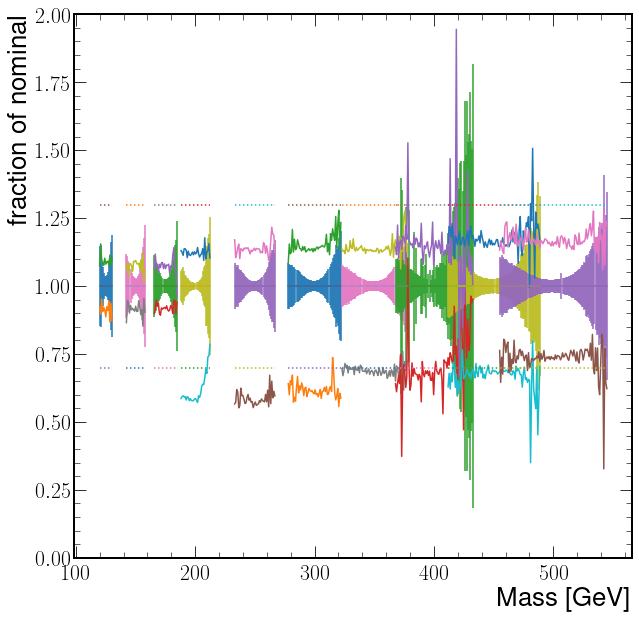

In [70]:
reg = 'SR1'
for mass in masses:
    print(make_sys_stats(mass,reg))    
plt.savefig('systematics/relative_sys_{}_{}.png'.format(era, reg))

/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.16765419321584485, 0.12449620461183297)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.09829006076205382, 0.1633089722596004)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.10561315359203072, 0.1285981942898895)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.2739419590535235, 0.1491867338042021)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.31959068697176995, 0.18113884310660922)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.31243202982892027, 0.22326547148879738)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.316991598480618, 0.18882739608552002)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.1761568767976126, 0.185891057227056)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.2000405858026093, 0.26849858758097045)


/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: divide by zero encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:6: RuntimeWarning: invalid value encountered in true_divide
  down_norm =(nominal+down)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: divide by zero encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:7: RuntimeWarning: invalid value encountered in true_divide
  up_norm =(nominal+up)/nominal
/tmp/ipykernel_15202/344296802.py:8: RuntimeWarning: invalid value encountered in true_divide
  std_norm = std/nominal


(-0.2536827496444235, 0.3042576294191659)


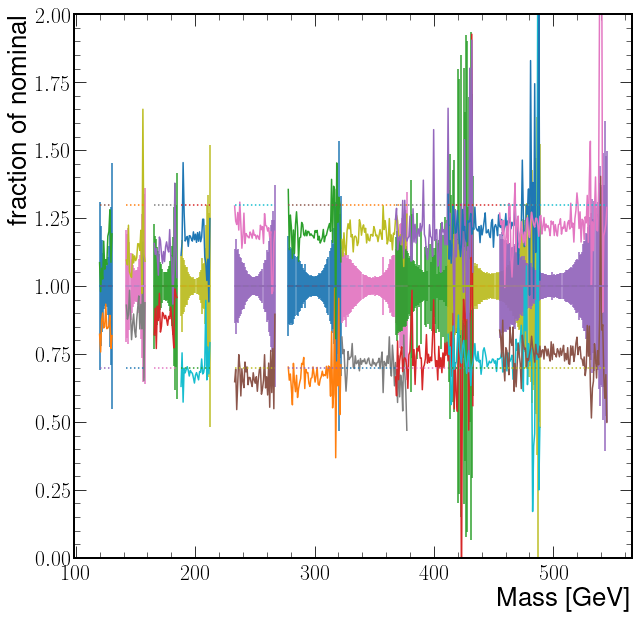

In [71]:
reg = 'SR2'
for mass in masses:
    print(make_sys_stats(mass,reg))    
plt.savefig('systematics/relative_sys_{}_{}.png'.format(era, reg))

In [72]:
df.mass

0          350.0
1          350.0
2          350.0
3          350.0
4          350.0
           ...  
1917212      NaN
1917213      NaN
1917214      NaN
1917215      NaN
1917216      NaN
Name: mass, Length: 1917217, dtype: float64

In [73]:
def make_sys_comp_plot(nominal, down, up, fit_unc, reg, mass):
    fig, ax = plt.subplots()
    ax.plot(bin_centers, 0/fit)
    ax.plot(bin_centers,up/fit, color='blue')
    ax.plot(bin_centers,down/fit, color='blue', label='mc sys')
    ax.plot(bin_centers,fit_unc/fit, color='red', label='fit sys')
    ax.plot(bin_centers,-fit_unc/fit, color='red')
    ax.set_ylim(-1.25,1.25)
    ax.legend(title = "{} {}".format(reg, mass), loc=1)
    ax.set_xlabel('DiLepMass [GEV]')
    ax.set_ylabel('value/nominal(fit)')
    hep.cms.label(loc=0,ax=ax,lumi=lumi,year=era, data=False)
    fig.savefig('fits/bff/sys_plot_{}_{}_{}.png'.format(era, reg, mass))
    return fig 

125.0 SR1
150.0 SR1
175.0 SR1
200.0 SR1
250.0 SR1
300.0 SR1
350.0 SR1
400.0 SR1
450.0 SR1
500.0 SR1
125.0 SR2
150.0 SR2
175.0 SR2
200.0 SR2
250.0 SR2
300.0 SR2
350.0 SR2
400.0 SR2
450.0 SR2
500.0 SR2


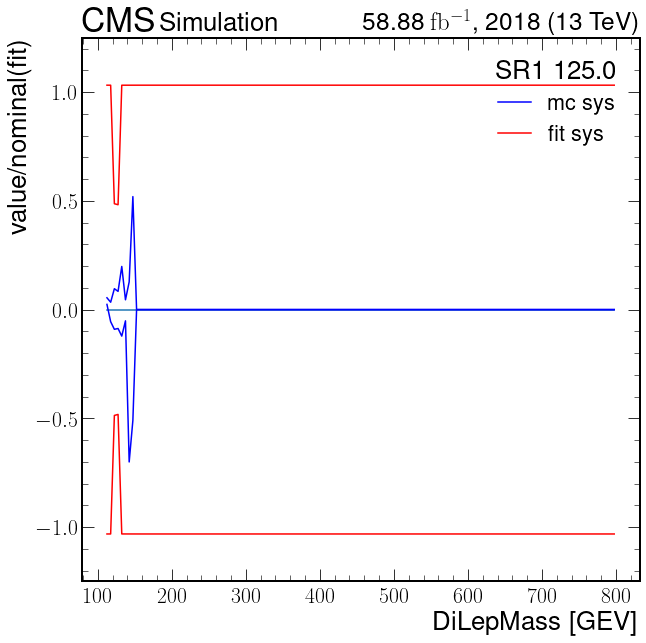

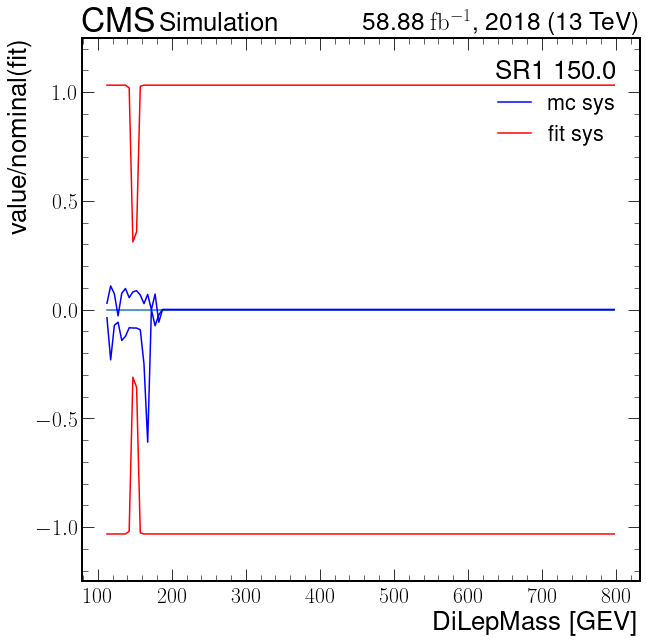

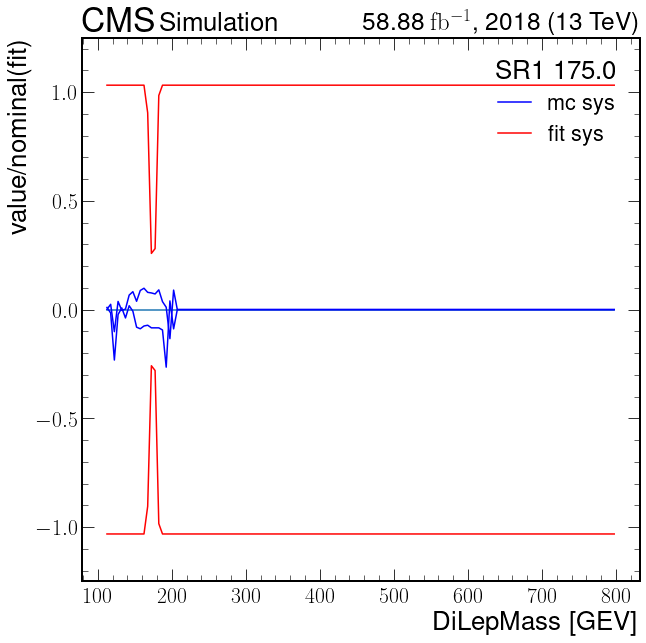

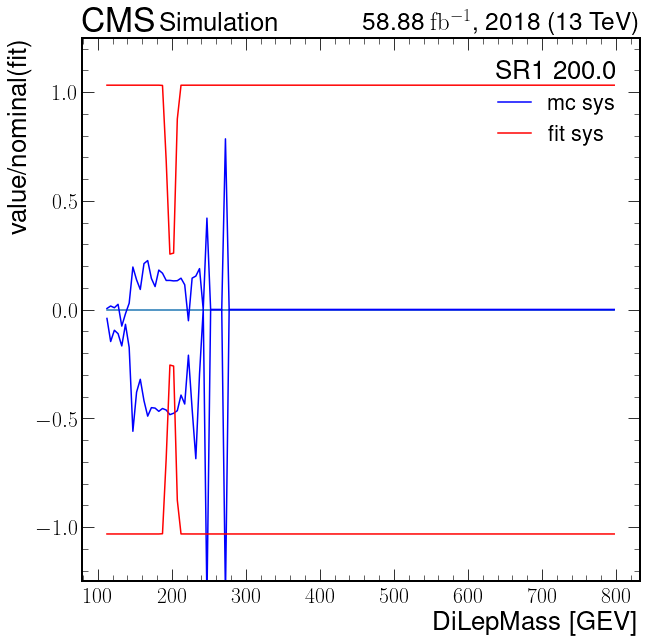

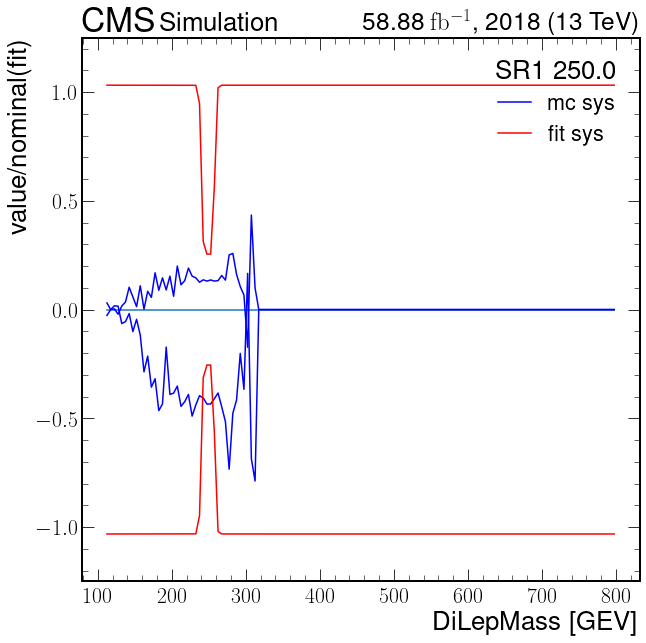

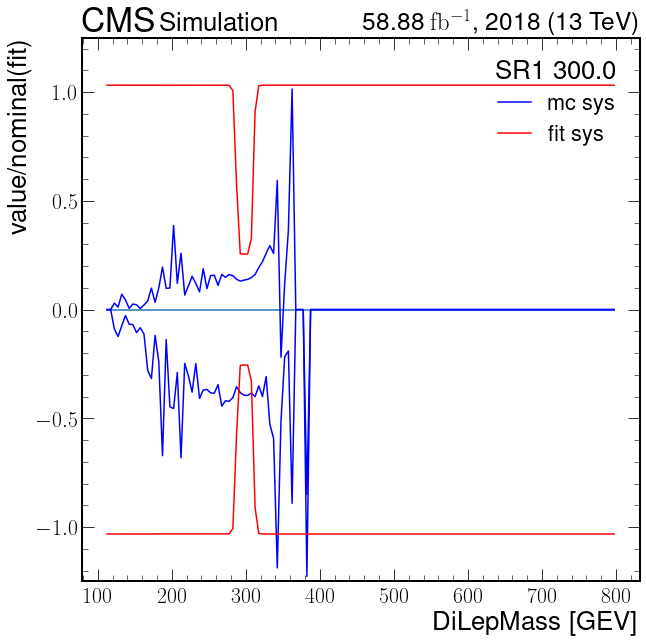

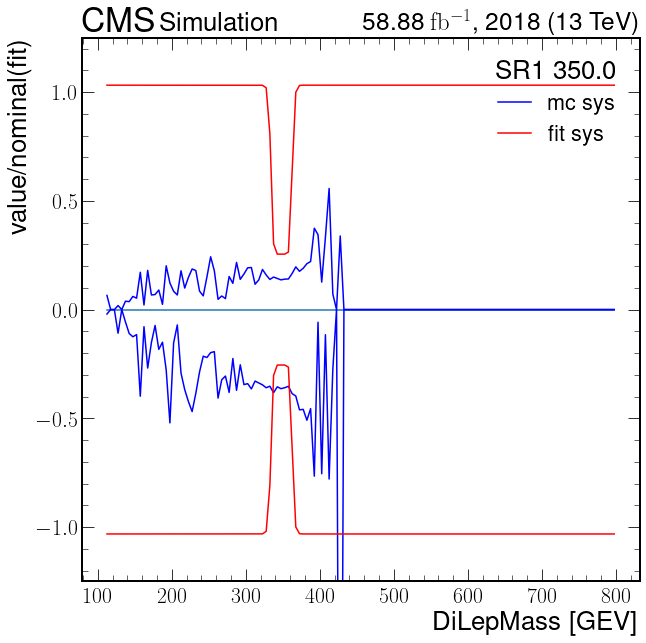

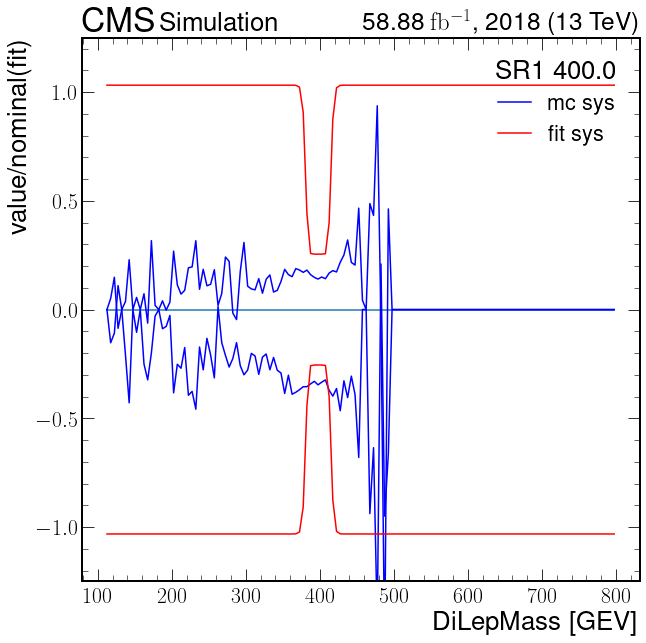

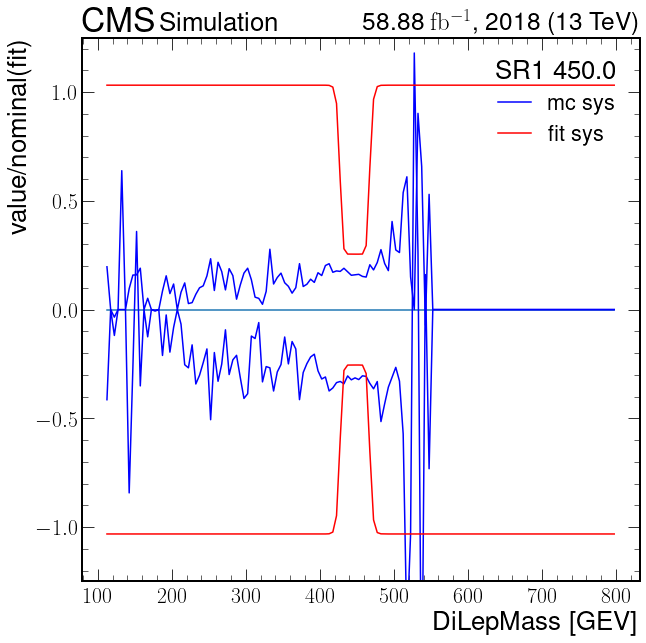

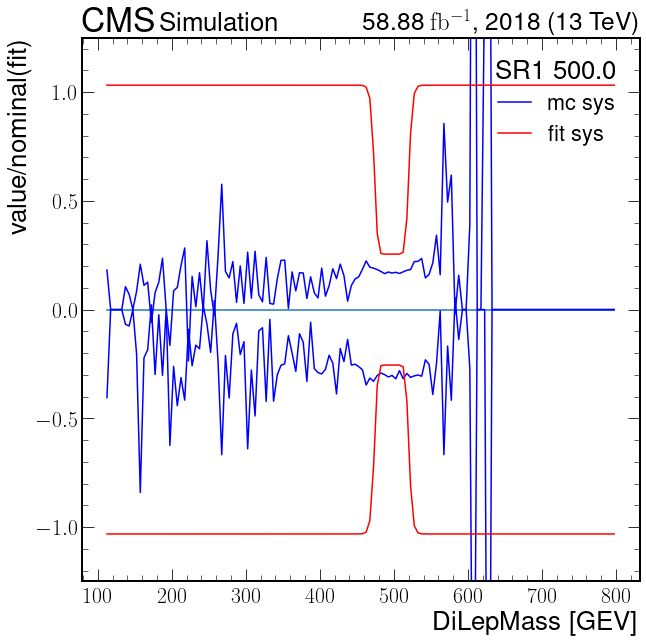

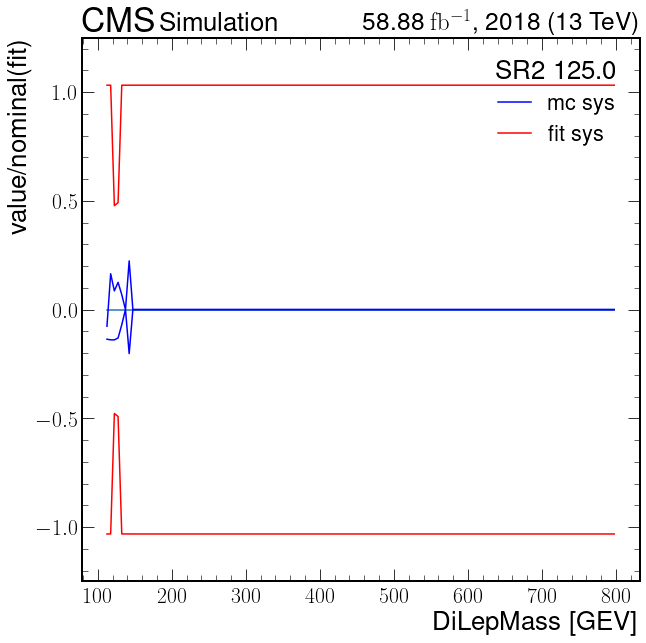

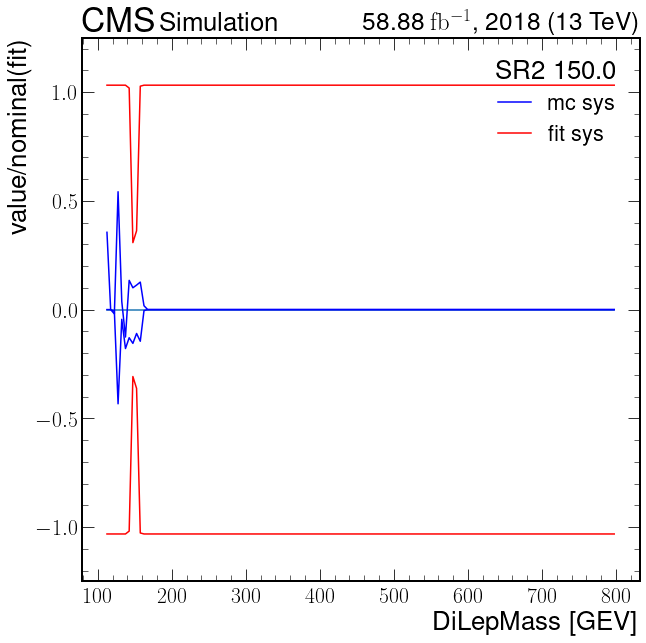

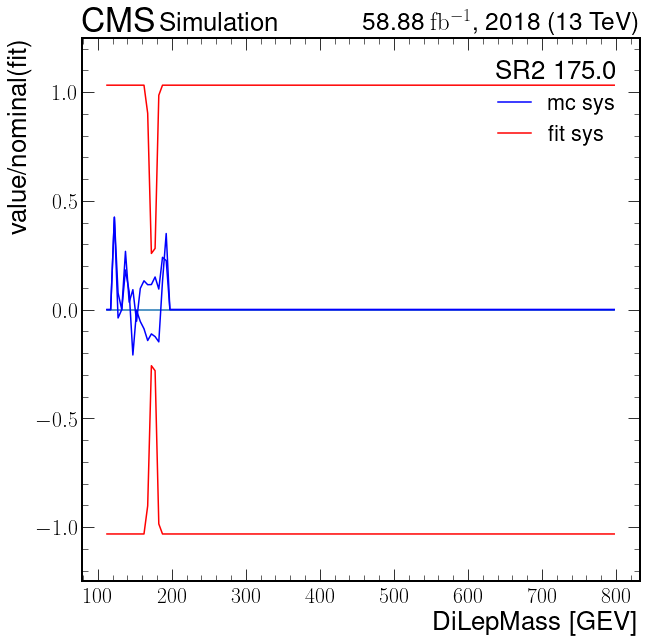

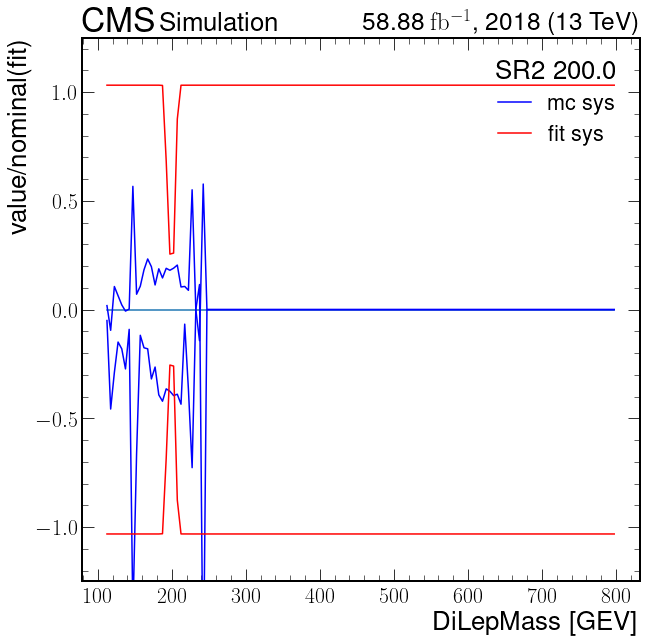

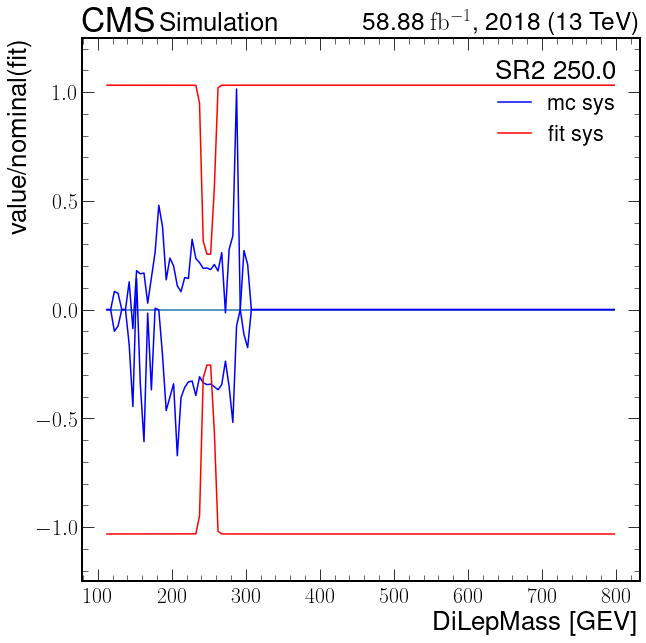

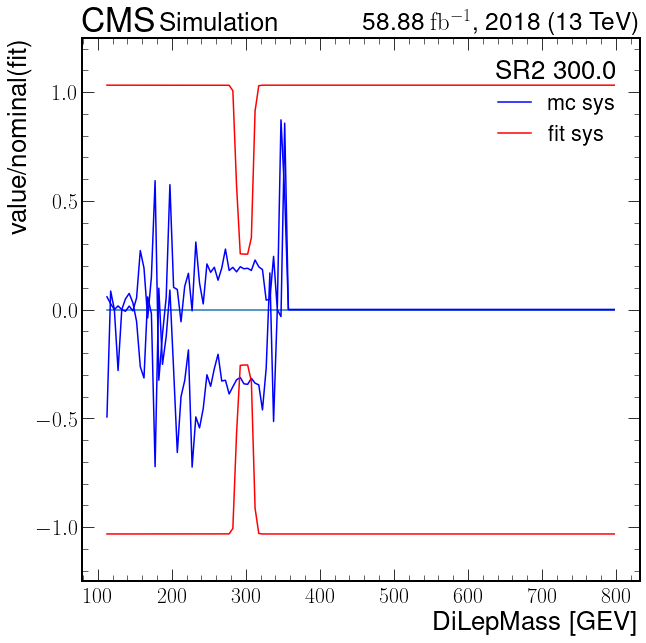

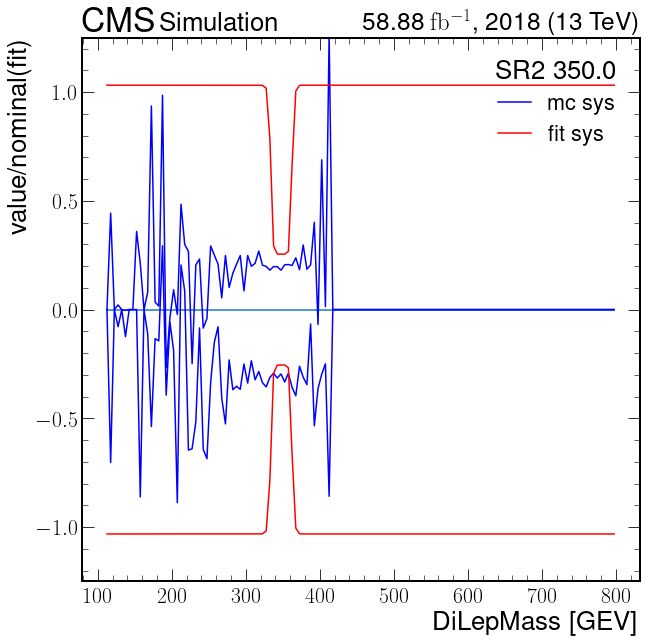

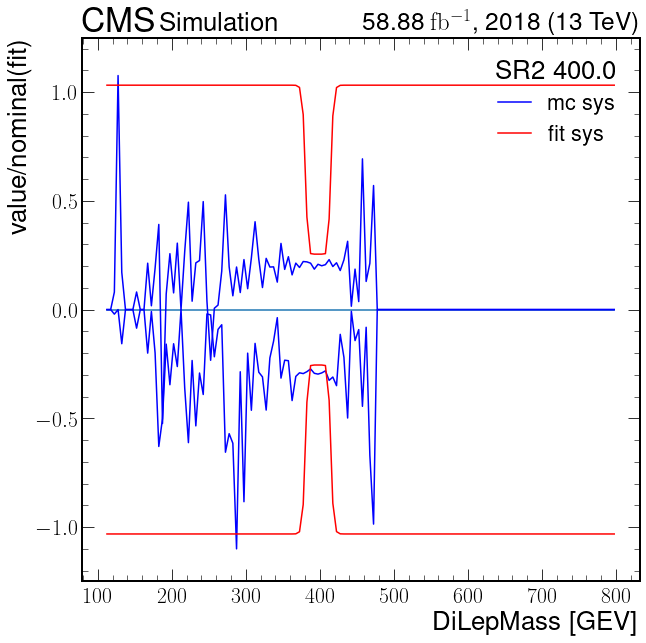

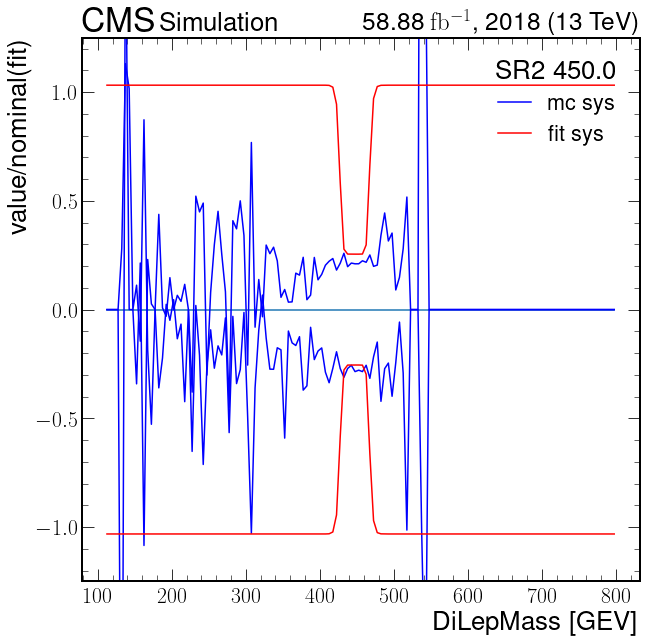

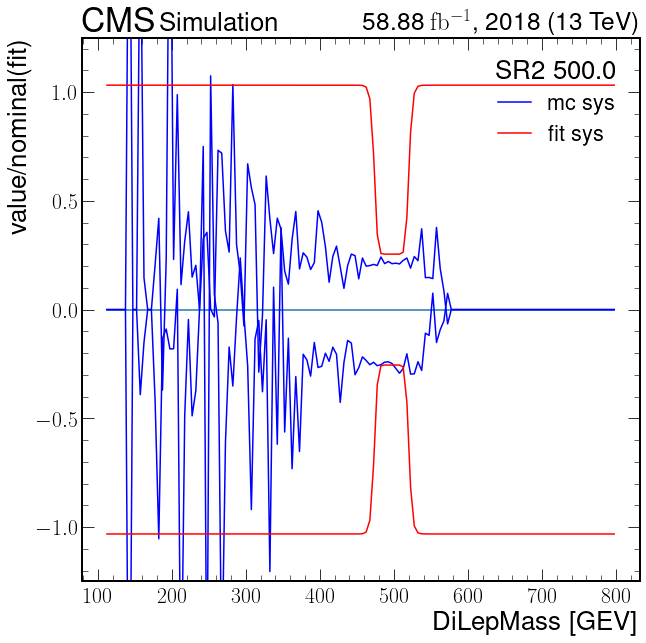

In [74]:
#make signal objects:
higgs_combine_plots = {}
for reg, mass_dict in plot_dict.items():
    higgs_combine_plots[reg] = {}
    for mass,signal_dict in mass_dict.items():
        print(mass, reg)
        fit = signal_dict['fit']
        fit_unc = signal_dict['fit_unc']
        # add constant systematic amount to account for mc systematics:
        sys_amount = .25
        fit_unc = (fit_unc**2 + (sys_amount*fit)**2)**.5
        hist = signal_dict['hist']
        bins = signal_dict['bins']
        bin_centers = compute_bin_centers(bins)
        nominal, down, up, std = make_sys(df[(df.mass==mass) & (df.dbs==0.04)], 'DiLepMass',reg, bins=bins)
        fit_up, fit_down = fit+fit_unc, fit-fit_unc
        make_sys_comp_plot(nominal, down, up, fit_unc, reg, mass)

        
        higgs_combine_plots[reg][mass] = {"fit": fit, 
                                         "fit_unc": fit_unc,
                                         "hist": nominal,
                                         "hist_down": down,
                                         "hist_up": up}

In [75]:
import pickle

In [76]:
with open('fits/bff/{}_signal_hists.pkl'.format(era), 'wb') as f:
    pickle.dump(higgs_combine_plots, f, protocol=2)

In [77]:
with open('fits/bff/{}_signal_hists.pkl'.format(era), 'rb') as f:
    test = pickle.load(f)

In [78]:
test

{'SR1': {125.0: {'fit': array([1.87309986e+01, 6.61580170e+01, 9.36887171e+02, 8.70440382e+02,
          1.92033346e+01, 2.80176923e+00, 8.41466182e-01, 3.47521406e-01,
          1.72325320e-01, 9.62910207e-02, 5.85410202e-02, 3.78992392e-02,
          2.57596843e-02, 1.82017972e-02, 1.32757234e-02, 9.94170668e-03,
          7.61288878e-03, 5.94201341e-03, 4.71523137e-03, 3.79626553e-03,
          3.09565851e-03, 2.55314300e-03, 2.12717583e-03, 1.78853103e-03,
          1.51626913e-03, 1.29513906e-03, 1.11386619e-03, 9.64001963e-04,
          8.39136634e-04, 7.34351756e-04, 6.45833550e-04, 5.70596107e-04,
          5.06280665e-04, 4.51008332e-04, 4.03270820e-04, 3.61848555e-04,
          3.25748709e-04, 2.94157892e-04, 2.66405733e-04, 2.41936614e-04,
          2.20287581e-04, 2.01070946e-04, 1.83960514e-04, 1.68680584e-04,
          1.54997143e-04, 1.42710752e-04, 1.31650780e-04, 1.21670707e-04,
          1.12644272e-04, 1.04462310e-04, 9.70301312e-05, 9.02653527e-05,
          8.40960